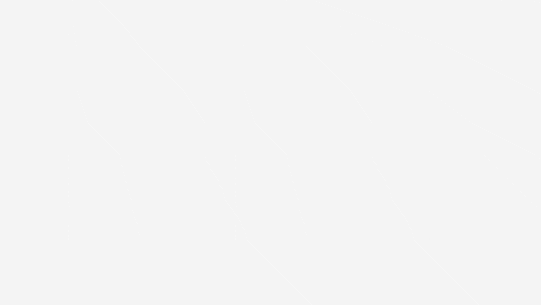

# Model fitting
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you some steps to prepare for model fitting.

By the end of this notebook you will be able to:
1. appreciate some steps to consider before fitting a model
2. know how to prepare for fitting a model

The datasets used in this notebook have already been filtered to include at least 4 leptons per event.

Contents: 

[Running a Jupyter notebook](#running) <br />
[To setup everytime](#setup_everytime) <br />
[Input data](#fraction) <br />
[Dealing with outliers](#outliers) <br />
  [Task 1 - Plot sigd0_2](#plot_sigd0_2) <br />
  [Task 2 - Remove sigd0_2 outliers](#select_sigd0_2) <br />
  [Task 3 - Plot ptconerel_0](#plot_ptconerel_0) <br /> 
  [Task 4 - Plot ptconerel_0 with log axis](#plot_ptconerel_0_log) <br />
  [Task 5 - Remove ptconerel_0 outliers](#select_ptconerel_0) <br />
  [Task 6 - Plot z0_2](#plot_z0_2) <br />
  [Task 7 - z0_2 mean](#mean_z0_2) <br />
  [Task 8 - z0_2 standard deviation](#std_z0_2) <br />
  [Task 9 - Remove z0_2 outliers](#select_z0_2) <br />
[Errors on independent variables](#errors_on_independent_vars) <br />
  [Task 10 - Check background correlations separately](#corr_bkg_separate) <br />
  [Task 11 - Check background correlations together](#corr_bkg_together) <br />
  [Task 12 - Check correlations above 0.85](#corr_above_85) <br />

<a id='running'></a>

## Running a Jupyter notebook

To run the whole Jupyter notebook, in the top menu click "Run" -> "Run all".

To propagate a change you've made to a piece of code, click "Run" -> "Run after".

You can also run a single code cell, by using the keyboard shortcut Shift+Enter.

<a id='setup_everytime'></a>

## To setup everytime

to be done every time you re-open this notebook

We're going to be using a number of tools to help us:
* pandas: lets us store data as dataframes, a format widely used in Machine Learning
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [10]:
import pandas as pd # to store data as dataframe
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting

<a id='fraction'></a>

## Input data

Samples to process, fraction of data used

In [11]:
samples_list = ['ttbar_lep','Zee','Zmumu','llll','ggH125_ZZ4lep'] # list of files to read
labels_list = ['ttbar background MC','Zee background MC','Zmumu background MC','llll background MC','Higgs signal MC'] # list of legend labels
#These are the main backgrounds and signal for a Higgs -> 4 lepton search
#note that these data are not measured data, but in fact MC simulated data

DataFrames = {} # define empty dictionary to hold dataframes
for s in samples_list: # loop over samples
    DataFrames[s] = pd.read_csv('/kaggle/input/4lepton/'+s+'.csv', index_col='entry') # read .csv file
    
DataFrames['data'] = pd.read_csv('/kaggle/input/4lepton/data.csv', index_col='entry') # read data.csv file

DataFrames
#uncomment the above to see the tables of data in the dictionary
#note each entry in DataFrames dictionary (e.g. DataFrames['ttbar_lep']) is a dataframe

{'ttbar_lep':          lep_pt_0   lep_pt_1   lep_pt_2   lep_pt_3  lep_eta_0  lep_eta_1  \
 entry                                                                      
 0       72.882969  38.832246  12.576012   7.013978  -0.912500   0.619830   
 1      132.460031  51.814488   7.977667   7.039771  -0.484337  -0.432240   
 2       74.547516  50.520613  12.462047   7.799593  -2.662162  -1.584950   
 3       39.905977  28.147189   9.649799   9.186890  -2.243924  -0.868191   
 4       33.729055  27.150857   9.456588   7.020979   1.976351   1.902421   
 ...           ...        ...        ...        ...        ...        ...   
 1026   138.097297  20.514396  15.370311  11.816060  -0.977767  -2.033095   
 1027    57.052246  54.549004  15.611801  15.060138   0.707714  -1.927078   
 1028    47.612863  44.278621  13.041843   7.166761  -0.362938   1.916020   
 1029    65.106645  60.042895  13.987725   8.105575  -0.451827  -0.041969   
 1030   183.709828  10.386254  10.364022   8.407727   0.711379 

In [16]:
for datasetName,Dataset in DataFrames.items():
    print(datasetName)
    Dataset.info()

ttbar_lep
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031 entries, 0 to 1030
Data columns (total 45 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lep_pt_0         1031 non-null   float64
 1   lep_pt_1         1031 non-null   float64
 2   lep_pt_2         1031 non-null   float64
 3   lep_pt_3         1031 non-null   float64
 4   lep_eta_0        1031 non-null   float64
 5   lep_eta_1        1031 non-null   float64
 6   lep_eta_2        1031 non-null   float64
 7   lep_eta_3        1031 non-null   float64
 8   lep_phi_0        1031 non-null   float64
 9   lep_phi_1        1031 non-null   float64
 10  lep_phi_2        1031 non-null   float64
 11  lep_phi_3        1031 non-null   float64
 12  lep_E_0          1031 non-null   float64
 13  lep_E_1          1031 non-null   float64
 14  lep_E_2          1031 non-null   float64
 15  lep_E_3          1031 non-null   float64
 16  lep_charge_0     1031 non-null   int64  
 17  lep_

<a id='outliers'></a>

## Dealing with outliers

An important aspect of dealing with outliers is cleaning the data. Part of this is applying Data Quality (DQ) requirements. A requirement that gives you the idea of the process is having leptons with tracks pointing back to close to the collision point. A variable of interest here is `lep_sigd0`. A low `lep_sigd0` means it's more likely to have come from the collision point, which is usually what we want.

As a first step to understanding isolation, let's plot `lep_sigd0_0`. _0 means it's the 0th lepton.

<a id='plot_sigd0_0'></a>

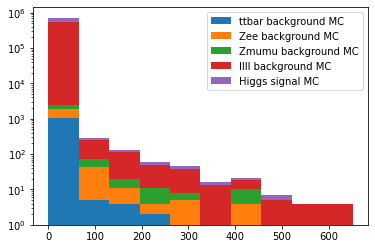

In [17]:
sigd0_0_lists = [] # define empty list
for s in samples_list: # loop over samples
    sigd0_0_lists.append(DataFrames[s]['lep_sigd0_0']) # append to list of values

plt.hist(sigd0_0_lists, # Input values
         stacked=True, # MC are stacked on top of each other
         log=True, # log y axis
         label=labels_list) # sequence of strings to match multiple datasets
plt.legend() # add legend to plot

Looking at the histogram above, the outliers seem to be above about 700.

Let's select events with `lep_sigd0_0` $<$ 700. Thus removing leptons far from the collision point.

<a id='select_sigd0_0'></a>

In [19]:
for s in DataFrames: # loop over DataFrames
    DataFrames[s] = DataFrames[s][DataFrames[s]['lep_sigd0_0']<700] # select low sigd0_0

We should check sigd0 for other leptons too. (There are 4 leptons per event in the files we're using).

<a id='plot_sigd0_2'></a>

### Task 1 - Plot a histogram of `lep_sigd0_2`

Use the code to plot `sigd0_0` [above](#plot_sigd0_0) to help you.

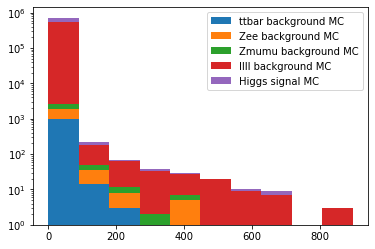

In [33]:
# your code here
sigd0_2_lists = [] #initialise empty list
for s in samples_list:
    sigd0_2_lists.append(DataFrames[s]['lep_sigd0_2'])

plt.hist(
    sigd0_2_lists,
    stacked = True,
    log = True,
    label = labels_list
)
plt.legend()

<a id='select_sigd0_2'></a>

### Task 2 - Remove `lep_sigd0_2` outliers

Use the code to remove `sigd0_0` outliers [above](#select_sigd0_0) to help you.

In [37]:
# your code here
for s in DataFrames:
    DataFrames[s] = DataFrames[s][DataFrames[s]['lep_sigd0_2']<700]

Another requirement you might need to impose is having isolated leptons. A variable of interest here is `lep_ptconerel`. A low value means well isolated and a high value means there's a  lot of noise going on around the lepton. Leptons with a lot of noise around them should probably be thrown away and not be used in your analysis.

<a id='plot_ptconerel_0'></a>

### Task 3 - plot `lep_ptconerel_0`

Use the code to plot `sigd0_0` [above](#plot_sigd0_0) to help you.

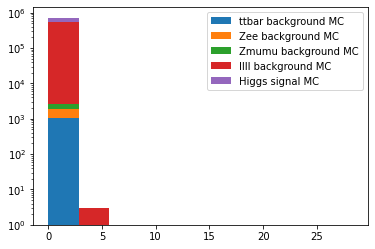

In [38]:
# your code here
lep_ptconerel_0_lists = [] #initialise empty list
for s in samples_list:
    lep_ptconerel_0_lists.append(DataFrames[s]['lep_ptconerel_0'])

plt.hist(
    lep_ptconerel_0_lists,
    stacked = True,
    log = True,
    label = labels_list
)
plt.legend()

What if the x-axis seems to go to high values, *suggesting* there are outliers, but since the y-axis doesn't go down past 1, you can't see where the outliers are?

We could force the y-axis to go down past 1.

<a id='plot_ptconerel_0_log'></a>

### Task 4 - plot `lep_ptconerel_0` again, but add a line `plt.ylim(0.9,None)` before `plt.legend`

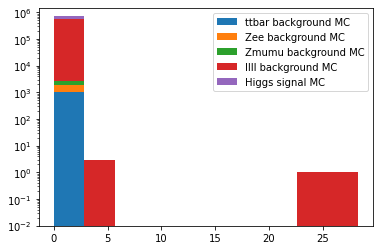

In [46]:
# your code here
lep_ptconerel_0_lists = [] #initialise empty list
for s in samples_list:
    lep_ptconerel_0_lists.append(DataFrames[s]['lep_ptconerel_0'])

plt.hist(
    lep_ptconerel_0_lists,
    stacked = True,
    log = True,
    label = labels_list
)
plt.ylim(0.01, None)
plt.legend()

Can you now see the outliers?

<a id='select_ptconerel_0'></a>

### Task 5 - remove the `lep_ptconerel_0` outliers

Use the code to remove `sigd0_0` outliers [above](#select_sigd0_0) to help you.

In [47]:
# your code here
for s in DataFrames:
    DataFrames[s] = DataFrames[s][DataFrames[s]['lep_ptconerel_0']<20]

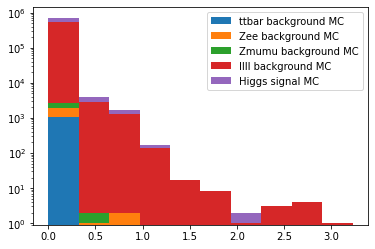

In [49]:
lep_ptconerel_0_lists = [] #initialise empty list
for s in samples_list:
    lep_ptconerel_0_lists.append(DataFrames[s]['lep_ptconerel_0'])

plt.hist(
    lep_ptconerel_0_lists,
    stacked = True,
    log = True,
    label = labels_list
)
plt.ylim(0.9, None)
plt.legend()

Another variable that quantifies whether leptons have tracks pointing back to close to the collision point is `lep_z0`. A low absolute value of `lep_z0` means it's more likely to have come from the collision point, which is usually what we want.

<a id='plot_z0_2'></a>

### Task 6 - plot `lep_z0_2`, ensuring you can see below 1 on the y-axis

Use the code to plot `ptconerel_0` [above](#plot_ptconerel_0_log) to help you.

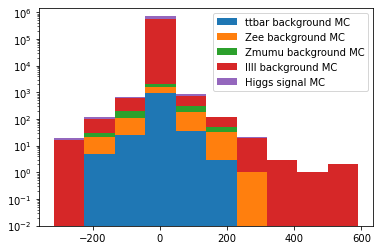

In [51]:
# your code here
lep_z0_2_lists = [] #initialise empty list
for s in samples_list:
    lep_z0_2_lists.append(DataFrames[s]['lep_z0_2'])

plt.hist(
    lep_z0_2_lists,
    stacked = True,
    log = True,
    label = labels_list
)
plt.ylim(0.01, None)
plt.legend()

It may not be clear here what is an outlier. Maybe we can use some sort of algorithm?

<a id='mean_z0_2'></a>

### Task 7 - Calculate the mean of `lep_z0_2` in the 'llll' DataFrame

In [55]:
# for you to complete
lep_z0_2_mean = DataFrames['llll']['lep_z0_2'].mean()
print(lep_z0_2_mean)

0.016874757303787156


<a id='std_z0_2'></a>

### Task 8 - calculate the standard deviation of `lep_z0_2` in the 'llll' DataFrame

In [56]:
# your code here

lep_z0_2_std = DataFrames['llll']['lep_z0_2'].std()
print(lep_z0_2_std)

5.071100711463317


<a id='select_z0_2'></a>

### Task 9 - remove events more than 50 standard deviations away from the mean of `lep_z0_2`

Use the code to remove `sigd0_0` outliers [above](#select_sigd0_0) to help you.

50 is chosen as an example. You may want to be stricter if you require very pure signal. Or you may want to be looser if you require high statistics. You could try different numbers and see how things look.

Remember that you have to remove data 50 standard deviations above and below the mean.

In [68]:
# your code here
flattened_data = np.concatenate(lep_z0_2_lists).flatten()


mean = np.mean(flattened_data)
print(mean)
std = np.std(flattened_data)
print(std)
  # Define threshold for outlier removal
threshold = abs(50 * std)
print(threshold)
  # Create a mask to identify non-outlier elements
mask = np.abs(flattened_data - mean) <= threshold

for s in DataFrames:
    DataFrames[s] = DataFrames[s][(DataFrames[s]['lep_z0_2']-mean)<= threshold]

0.03402760296147136
5.621372991507941
281.06864957539705


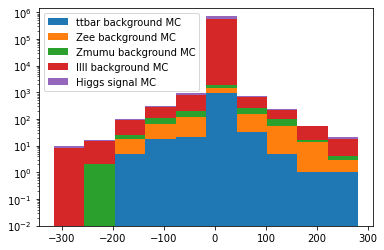

In [69]:
lep_z0_2_lists = [] #initialise empty list
for s in samples_list:
    lep_z0_2_lists.append(DataFrames[s]['lep_z0_2'])

plt.hist(
    lep_z0_2_lists,
    stacked = True,
    log = True,
    label = labels_list
)
plt.ylim(0.01, None)
plt.legend()

In reality you would remove outliers for many more variables, but if you've grasped the idea, you're ready to move on. If you want to try more variables, take a look at the rest of `lep_ptconerel`, `lep_etconerel`, `lep_sigd0`, `lep_z0`; for all leptons 0,1,2,3

<a id='errors_on_independent_vars'></a>

## Errors on independent variables

An important point regarding errors on independent variables is to check for correlations between variables. You may later want to use one/some of these variables as parameters of interest in a statistical fit, so it's especially important to understand the correlations between them. When trying to reduce uncertainties in your final measurement, you could start by trying to reduce uncertainties in the variable that's most correlated with the variable you're eventually measuring.

Let's first define a function to draw a correlation matrix.

In [70]:
def correlations(data):
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = data.corr()
    
    plt.figure(figsize=(14, 14)) # change figure size
    heatmap1 = plt.pcolor(corrmat) # get heatmap
    plt.colorbar(heatmap1) # plot colorbar
    plt.title("correlations") # set title
    x_variables = corrmat.columns.values # get variables from data columns
    plt.xticks(np.arange(len(x_variables))+0.5, x_variables, rotation=90) # x-tick for each label
    plt.yticks(np.arange(len(x_variables))+0.5, x_variables) # y-tick for each label

Now draw the correlations for your signal

<a id='corr_sig'></a>

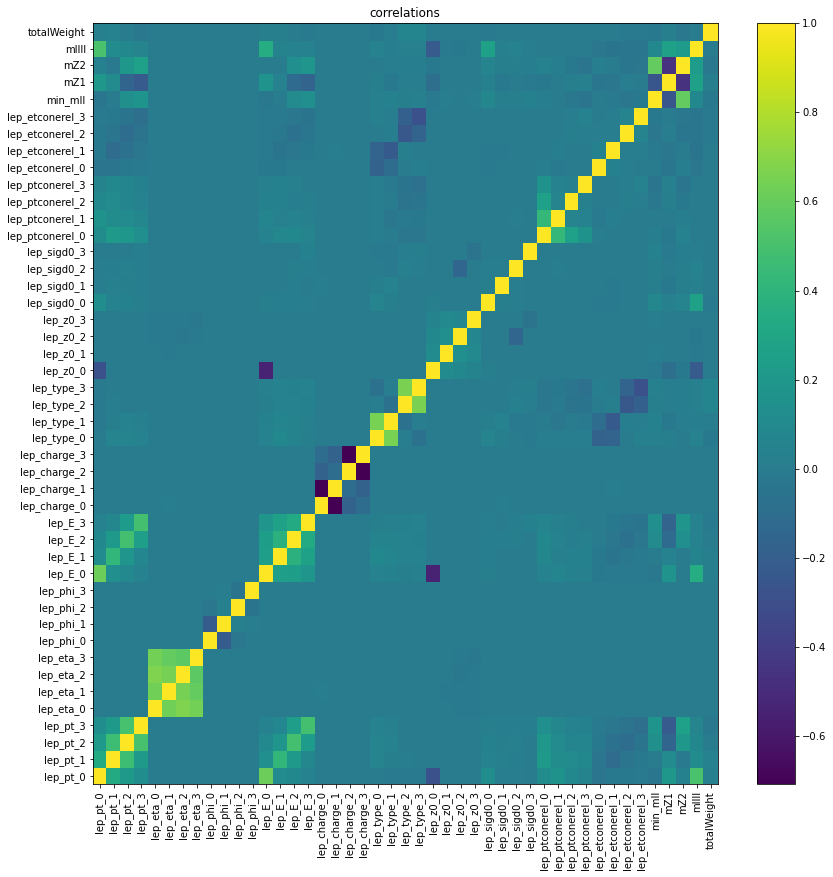

In [71]:
correlations(DataFrames['ggH125_ZZ4lep']) # draw correlations for signal

Positive correlation means that if one variable increases, the other increases too. Negative correlation means that if one variable increases, the other decreases. Both high amounts of positive correlation and high amounts of negative correlation are important. 

If a variable pair is close to 100% correlated, there would be no point using both of those variables in e.g. a Machine Learning algorithm. Since using both wouldn't add any new information, it would be better to use only one.

However, some correlation is needed between the variables you want to use in e.g. a Machine Learning algorithm, since that's exactly what a ML algorithm exploits - correlations between variables in many dimensions.

<a id='corr_bkg_separate'></a>

### Task 10 - Check correlations for all your background DataFrames

Use the code to check correlations for signal [above](#corr_sig) to help you.

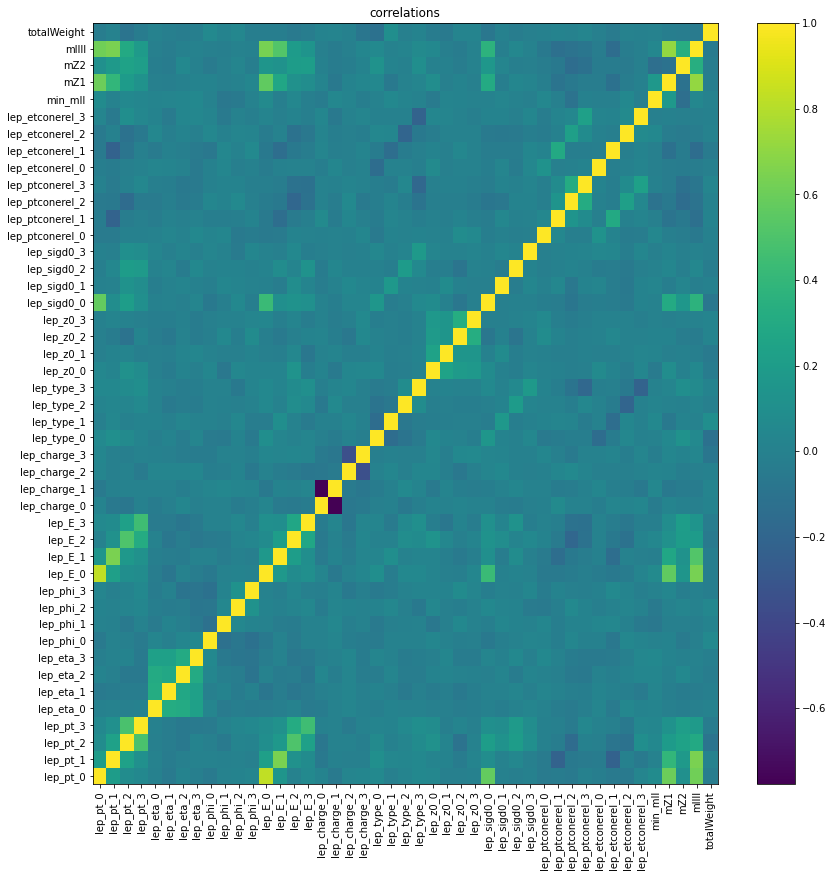

In [72]:
# your code here
#ttbar_lep correlations
correlations(DataFrames['ttbar_lep']) # draw correlations for signal


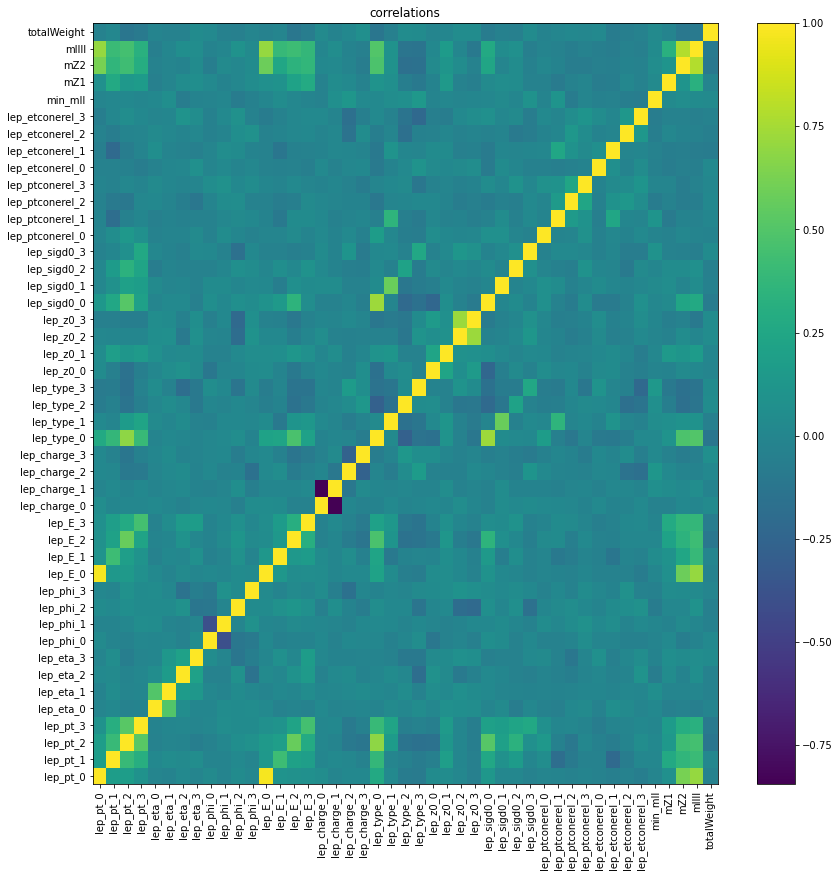

In [73]:
# your code here
#Zee correlations

correlations(DataFrames['Zee'])

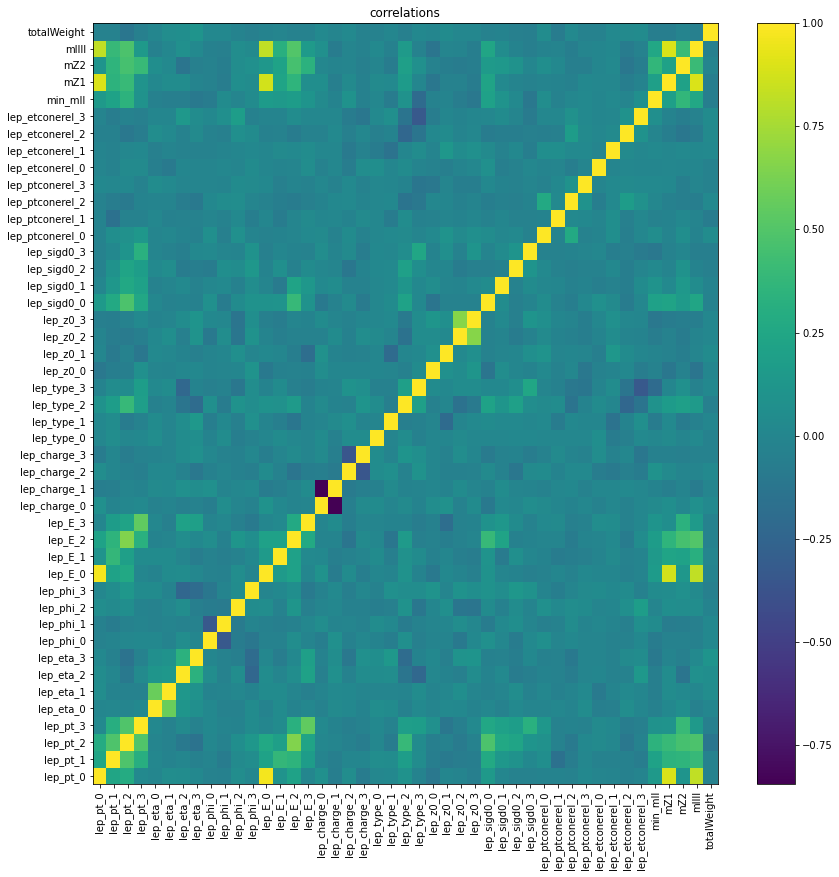

In [74]:
# your code here
#Zmumu correlations

correlations(DataFrames['Zmumu'])

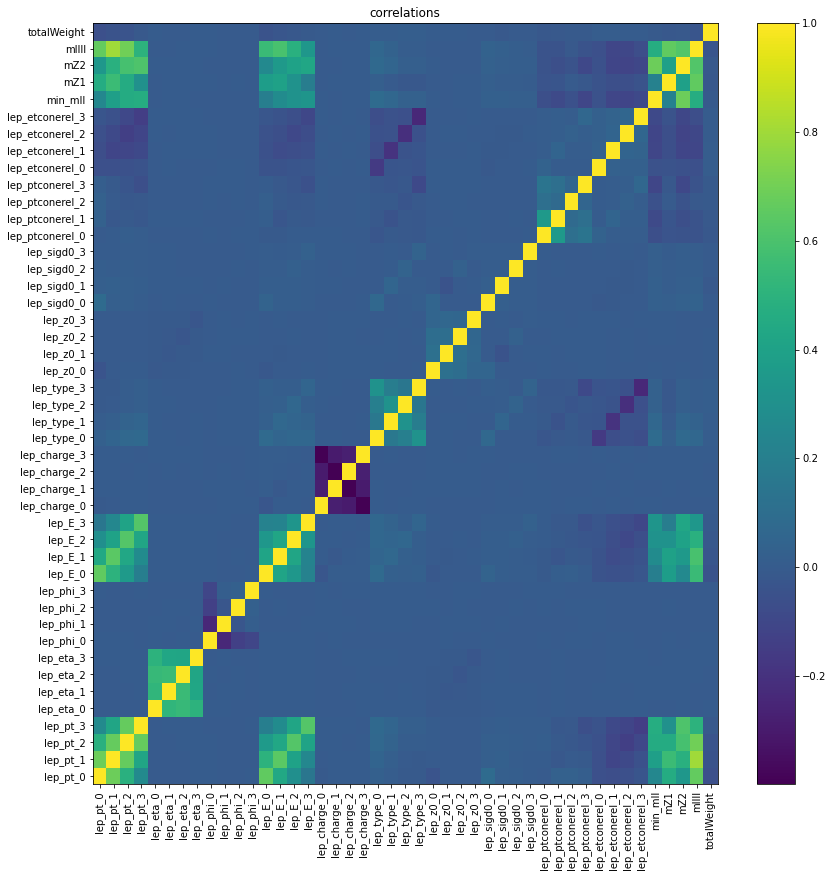

In [75]:
# your code here
#llll correlations

correlations(DataFrames['llll'])

It might also be useful to check correlations when all backgrounds are considered together, rather than separately.

You can merge DataFrames like this

In [ ]:
pd.concat([DataFrames['llll'],DataFrames['ttbar_lep']]) # merge dataframes into one

<a id='corr_bkg_together'></a>

### Task 11 - check the correlations for all backgrounds merged into one DataFrames

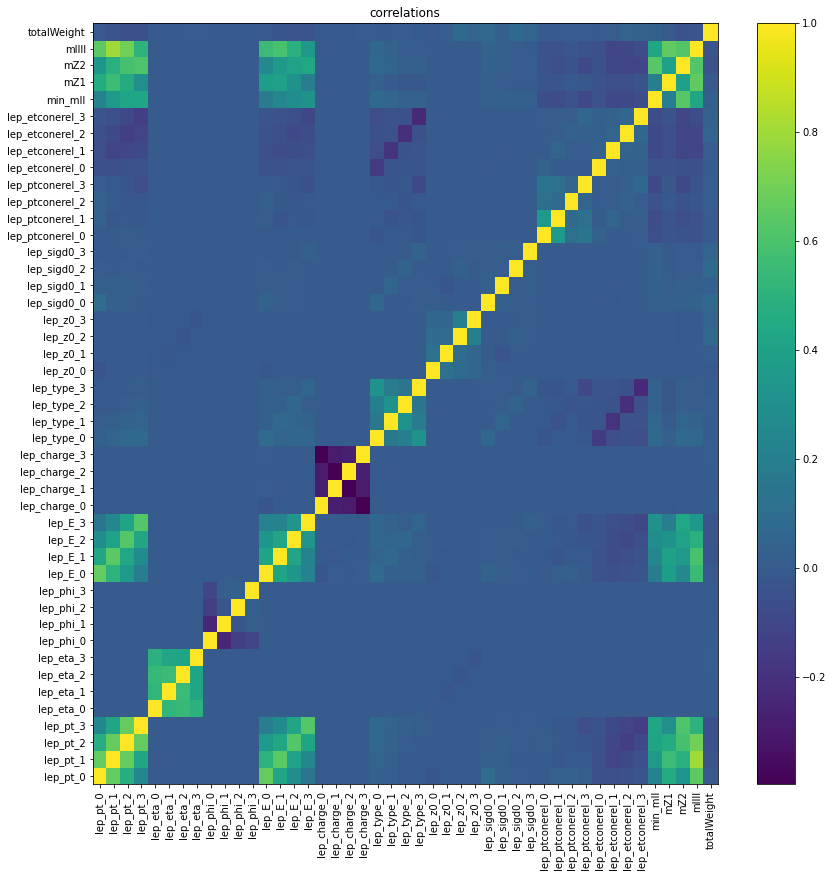

In [76]:
# your code here
correlations(pd.concat([DataFrames['llll'],DataFrames['ttbar_lep'], DataFrames['Zee'],DataFrames['Zmumu']]))

You may also have multiple signals. If this is the case, you may want to check correlations of all signals together. So far in this notebook, we've only considered one signal. But you should get the idea from merging the different backgrounds.

If you have correlations greater than about 0.85, you may want to consider not using both variables in e.g. your ML algorithm. This number 0.85 isn't set in stone. If you later find that you're overtraining your ML algorithm due to having too many variables, you could lower this 0.85 threshold to remove more varibales.

We could check if there any pairs correlated greater than 0.85 in the signal like:

In [77]:
corrmat = DataFrames['ggH125_ZZ4lep'].corr() # get correlation matrix
for col in corrmat.columns: # loop over columns
    truth = corrmat[(corrmat[col]>0.85) & (corrmat[col]<1)] # get cells with large correlation
    if len(truth.index)>0: # if any cells with large correlation
        print(col, truth.index[0], corrmat[col][truth.index[0]]) # print variables and correlation

As we get no output here, there are no pairs of variables that have a correlation of greater than 0.85 in our signal data.

<a id='corr_above_85'></a>

### Task 12 - check for correlations greater than 0.85 for all backgrounds separately

In [78]:
# your code here
for s in samples_list:
    print(s)
    corrmat = DataFrames[s].corr() # get correlation matrix
    for col in corrmat.columns: # loop over columns
        truth = corrmat[(corrmat[col]>0.85) & (corrmat[col]<1)] # get cells with large correlation
        if len(truth.index)>0: # if any cells with large correlation
            print(col, truth.index[0], corrmat[col][truth.index[0]]) # print variables and correlation
    print()

ttbar_lep

Zee
lep_pt_0 lep_E_0 0.9712625510423778
lep_E_0 lep_pt_0 0.9712625510423778

Zmumu
lep_pt_0 lep_E_0 0.9704211890643638
lep_E_0 lep_pt_0 0.9704211890643638
mZ1 lep_pt_0 0.8981599790873608
mllll mZ1 0.8978138631226861

llll

ggH125_ZZ4lep



In one of the backgrounds, there's a high correlation between `mZ1` and 2 other variables. (Which background and which other variables?)

You could remove it from your ML inputs like

In [79]:
ML_inputs = list(corrmat.columns) # make list from correlation matrix columns
ML_inputs.remove('mZ1') # remove element from list
ML_inputs # print list

['lep_pt_0',
 'lep_pt_1',
 'lep_pt_2',
 'lep_pt_3',
 'lep_eta_0',
 'lep_eta_1',
 'lep_eta_2',
 'lep_eta_3',
 'lep_phi_0',
 'lep_phi_1',
 'lep_phi_2',
 'lep_phi_3',
 'lep_E_0',
 'lep_E_1',
 'lep_E_2',
 'lep_E_3',
 'lep_charge_0',
 'lep_charge_1',
 'lep_charge_2',
 'lep_charge_3',
 'lep_type_0',
 'lep_type_1',
 'lep_type_2',
 'lep_type_3',
 'lep_z0_0',
 'lep_z0_1',
 'lep_z0_2',
 'lep_z0_3',
 'lep_sigd0_0',
 'lep_sigd0_1',
 'lep_sigd0_2',
 'lep_sigd0_3',
 'lep_ptconerel_0',
 'lep_ptconerel_1',
 'lep_ptconerel_2',
 'lep_ptconerel_3',
 'lep_etconerel_0',
 'lep_etconerel_1',
 'lep_etconerel_2',
 'lep_etconerel_3',
 'min_mll',
 'mZ2',
 'mllll',
 'totalWeight']

Notice how `mZ1` is gone?

And that’s it! Is there another analysis to which you can apply these principles?